In [1]:
import scipy as sps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as sps
import warnings
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm_notebook

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)

### 0. Загрузка датасета

Загрузим проеобразованные данные.

In [2]:
data = pd.read_csv('data/3k_processed_data.csv')

data

,status,y,ts,x,session,begin
0,0,0.000000,0,0.000000,0,1
1,0,0.291129,9,-0.644802,0,0
2,0,1.229173,17,-0.243663,0,0
3,0,13.056778,25,2.447144,0,0
4,0,21.475057,33,-3.184499,0,0
...,...,...,...,...,...,...
312283,2,1952.374310,679,-1286.091051,2999,0
312284,2,1952.374310,687,-1286.091051,2999,0
312285,2,1952.374310,695,-1286.091051,2999,0
312286,2,1952.374310,703,-1286.091051,2999,0


### 1. Визуализация траекторий

Визуализируем несколько сессий. Т.к. данные были преобразованы, то наносить их на карту бессмысленно.

In [6]:
sessions = []

for i in range(6):
    sessions.append(data[data.session == i].copy())

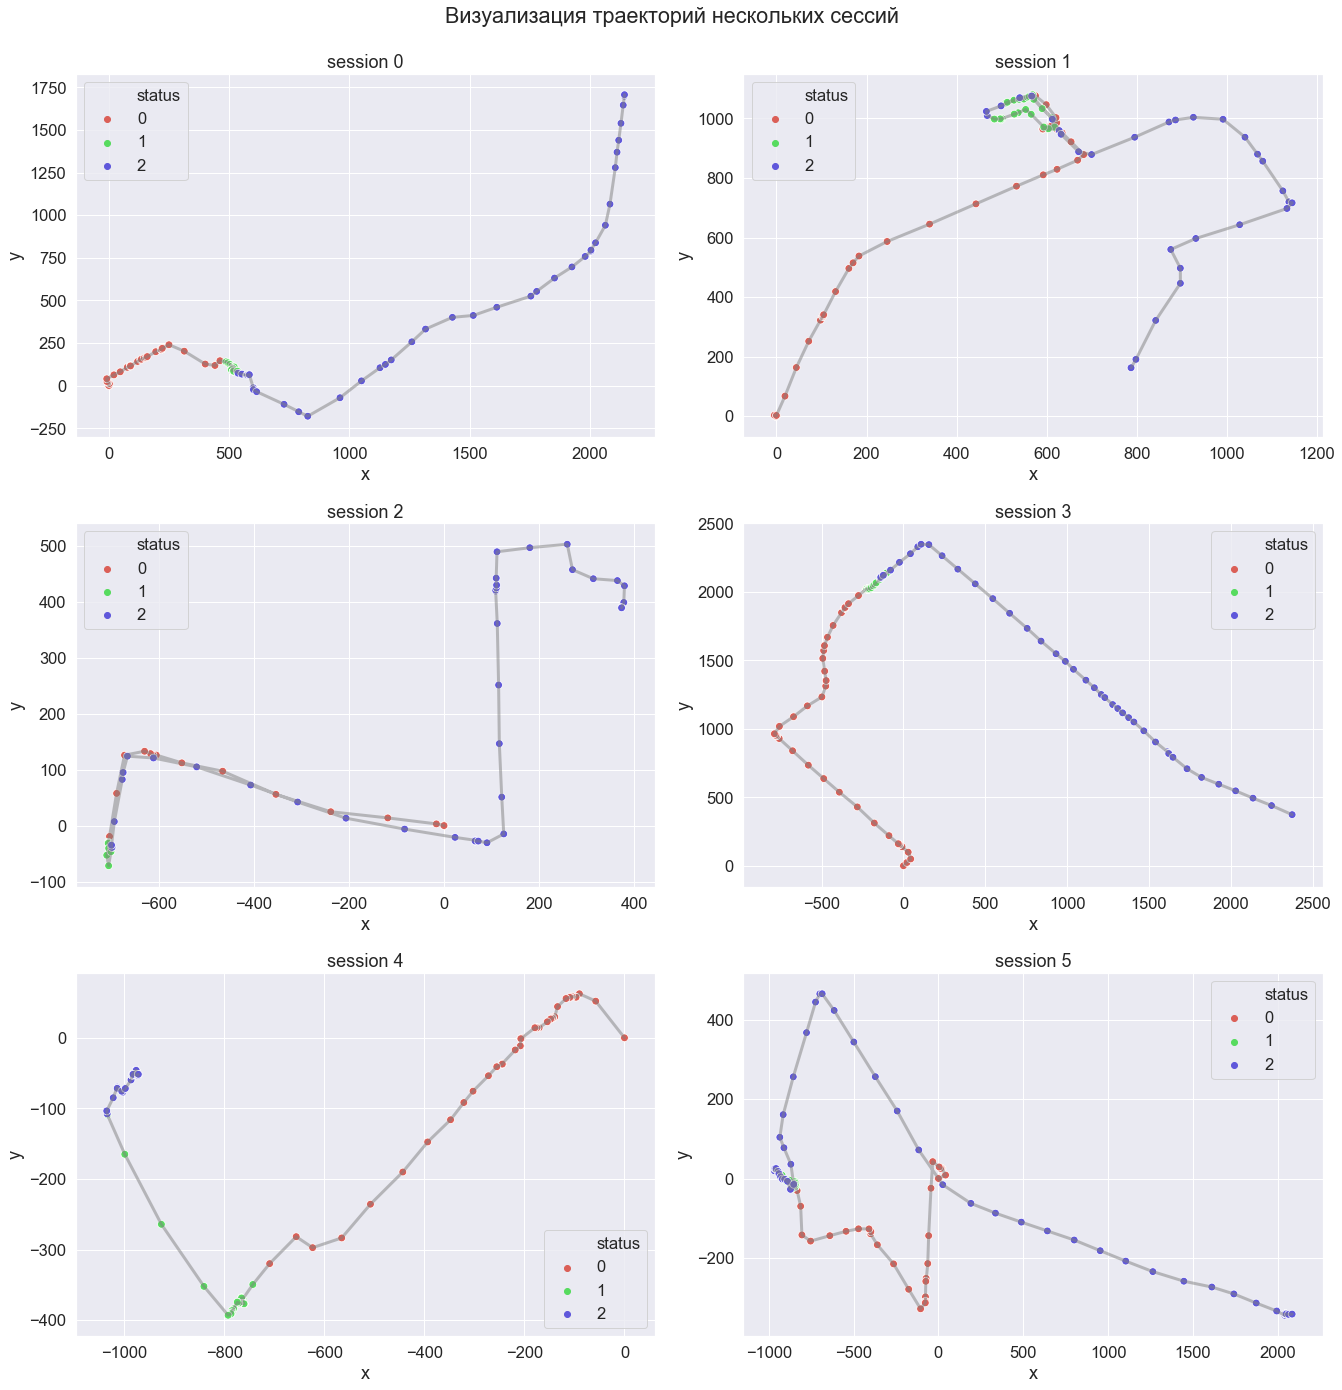

In [8]:
plt.figure(figsize=(19, 19))
plt.suptitle('Визуализация траекторий нескольких сессий', y=1.02, x=0.5)

for i in range(6):
    plt.subplot(3, 2, i+1)
    
    plt.plot(sessions[i].x, sessions[i].y, alpha=0.5, color='grey', lw=3)
    
    sns.scatterplot(x='x', y='y', data=sessions[i], hue='status',
                    palette=sns.color_palette('hls', 3), alpha=1, s=60)
    plt.title(f'session {i}')
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.tight_layout()

Визуально, не принимая во внимание статус, можно примерно определить точки остановки лишь для первых двух сессий. 

### 2. Скорость движения

Логично предположить, точка посадки пассажира связана со скоростью водителя. Во время посадки водитель стоит на месте.

Для определения средней скорости на отрезке между точками добавим признаки расстояния до предыдущей точки и расстояния, от данной точки до предыдущей.

In [46]:
new_data = data.copy()

new_data['delay'] = new_data['ts']
new_data.loc[1:, 'delay'] = (new_data['delay'].values[1:] - 
                             new_data['delay'].values[:-1])

dist = np.sqrt((new_data['x'].values[1:] - new_data['x'].values[:-1])**2 + 
               (new_data['y'].values[1:] - new_data['y'].values[:-1])**2)
               
new_data['dist'] = 0
new_data.loc[1:, 'dist'] = dist

new_data.loc[new_data['begin'] == 1, 'delay'] = 0
new_data.loc[new_data['begin'] == 1, 'av_speed'] = 0

new_data['av_speed'] = new_data['dist'] / new_data['delay']

new_data.head()

,status,y,ts,x,session,begin,delay,dist,av_speed
0,0,0.000000,0,0.000000,0,1,0,0.000000,NaN
1,0,0.291129,9,-0.644802,0,0,9,0.707478,0.078609
2,0,1.229173,17,-0.243663,0,0,8,1.020216,0.127527
3,0,13.056778,25,2.447144,0,0,8,12.129826,1.516228
4,0,21.475057,33,-3.184499,0,0,8,10.128318,1.266040


Попробуем сравнить распределение значений статуса с распределением средней скорости.

In [47]:
new_sessions = []

for i in range(6):
    new_sessions.append(new_data[new_data.session == i].copy())

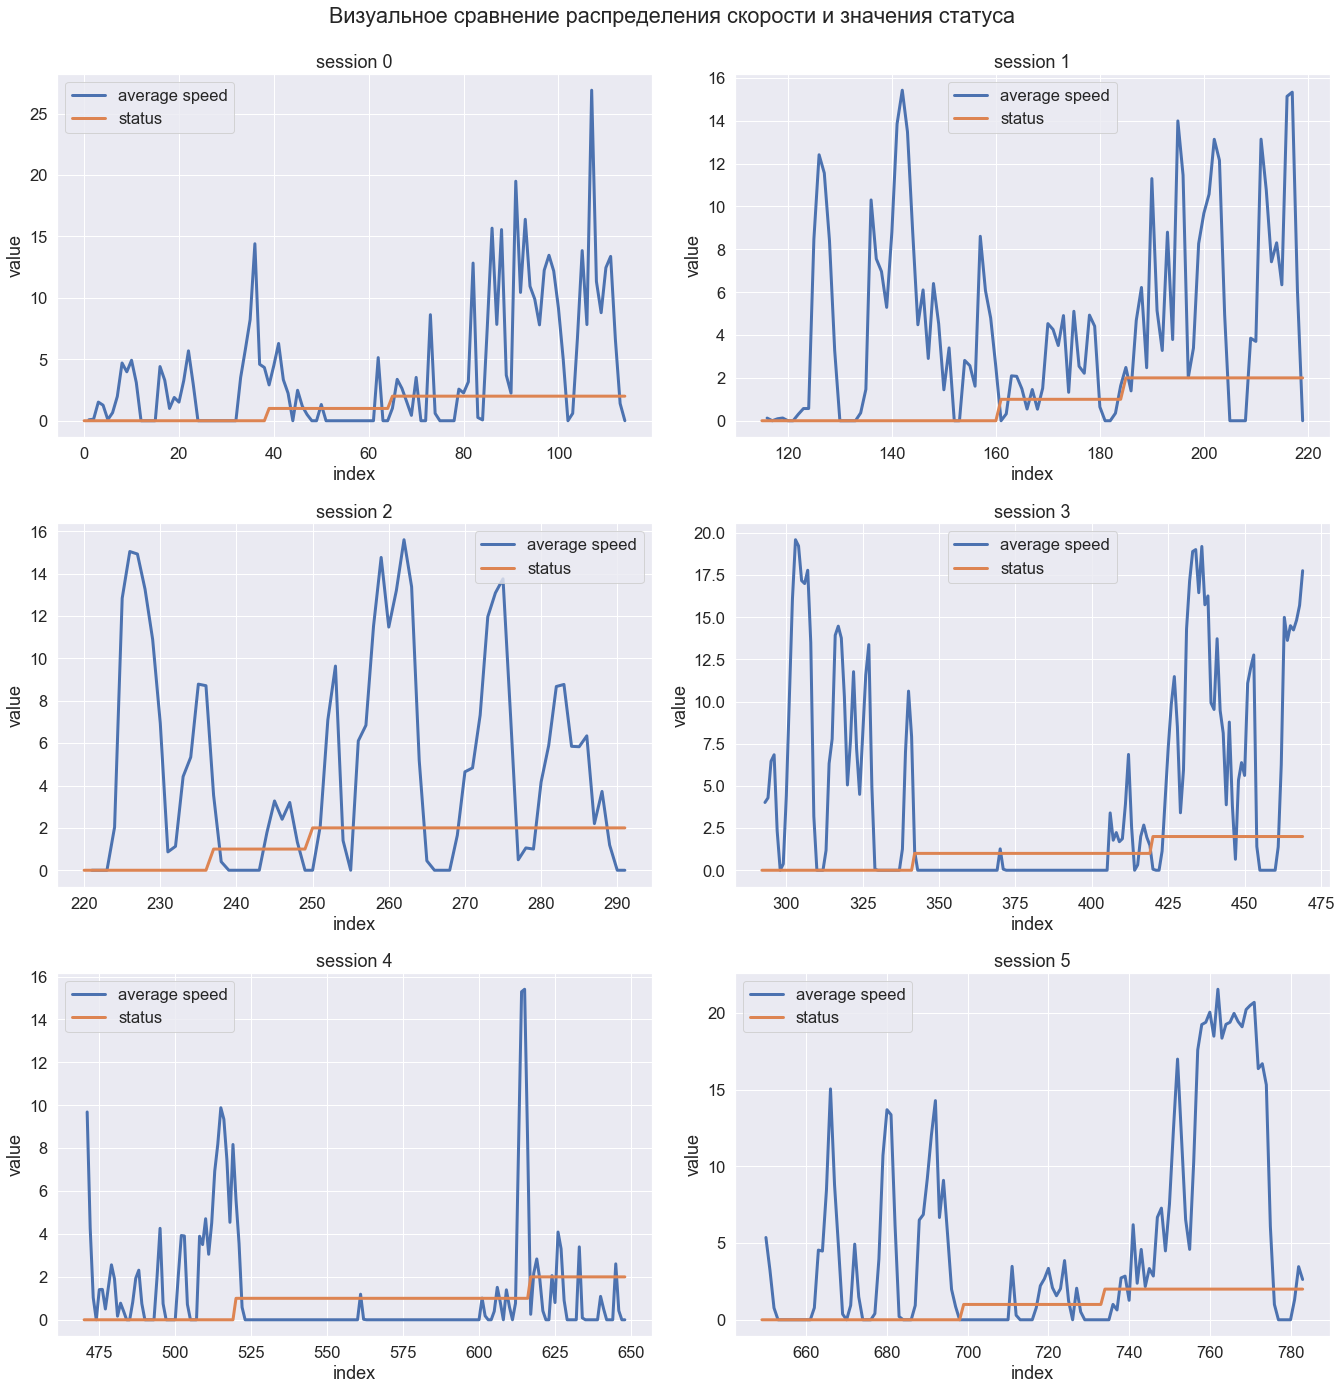

In [48]:
plt.figure(figsize=(19, 19))
plt.suptitle('Визуальное сравнение распределения скорости и\
 значения статуса', y=1.02, x=0.5)

for i in range(6):
    plt.subplot(3, 2, i+1)
    
    plt.plot(new_sessions[i].index, new_sessions[i].av_speed,
             lw=3, label='average speed')
    plt.plot(new_sessions[i].index, new_sessions[i].status,
             lw=3, label='status')
    
    plt.title(f'session {i}')
    plt.xlabel('index')
    plt.ylabel('value')
    
    plt.legend()
    
plt.tight_layout()

По графикам видно, что во всех случаях точка смены статуса находится близко к точке локального минимума графика скорости, принимающего значение 0.

### 3. Направление движения

При посадке пассажира водитель обычно поворачивает, паркуется или заезжает во двор. Иными словами, совершает множество поворотов. Ведём параметр угла вектора, соединяющего две соседние точки сессии. Угол будет изменять от $-\pi$ до $\pi$

In [56]:
new_data['x_diff'] = new_data.x
new_data.loc[1:, 'x_diff'] = new_data.x.values[1:] - new_data.x.values[:-1]

new_data['y_diff'] = new_data.y
new_data.loc[1:, 'y_diff'] = new_data.y.values[1:] - new_data.y.values[:-1]

new_data.loc[new_data['begin'] == 1, 'x_diff'] = 0
new_data.loc[new_data['begin'] == 1, 'y_diff'] = 0

angles = [np.arctan2(y_diff, x_diff) for y_diff, x_diff in zip(new_data.y_diff, new_data.x_diff)]

new_data['angle'] = angles
new_data.loc[new_data.angle == 0, 'angle'] = np.nan
new_data.loc[new_data['begin'] == 1, 'angle'] = 0.

# когда такси стоит, оно сохраняет направление
new_data.loc[:, 'angle'].fillna(method='pad', inplace=True)

In [57]:
new_data.head()

,status,y,ts,x,session,begin,delay,dist,av_speed,x_diff,y_diff,angle
0,0,0.000000,0,0.000000,0,1,0,0.000000,NaN,0.000000,0.000000,0.000000
1,0,0.291129,9,-0.644802,0,0,9,0.707478,0.078609,-0.644802,0.291129,2.717491
2,0,1.229173,17,-0.243663,0,0,8,1.020216,0.127527,0.401139,0.938044,1.166697
3,0,13.056778,25,2.447144,0,0,8,12.129826,1.516228,2.690807,11.827605,1.347101
4,0,21.475057,33,-3.184499,0,0,8,10.128318,1.266040,-5.631643,8.418279,2.160397


In [58]:
new_data.to_csv('data/3k_data_features')

In [59]:
new_sessions = []

for i in range(6):
    new_sessions.append(new_data[new_data.session == i].copy())

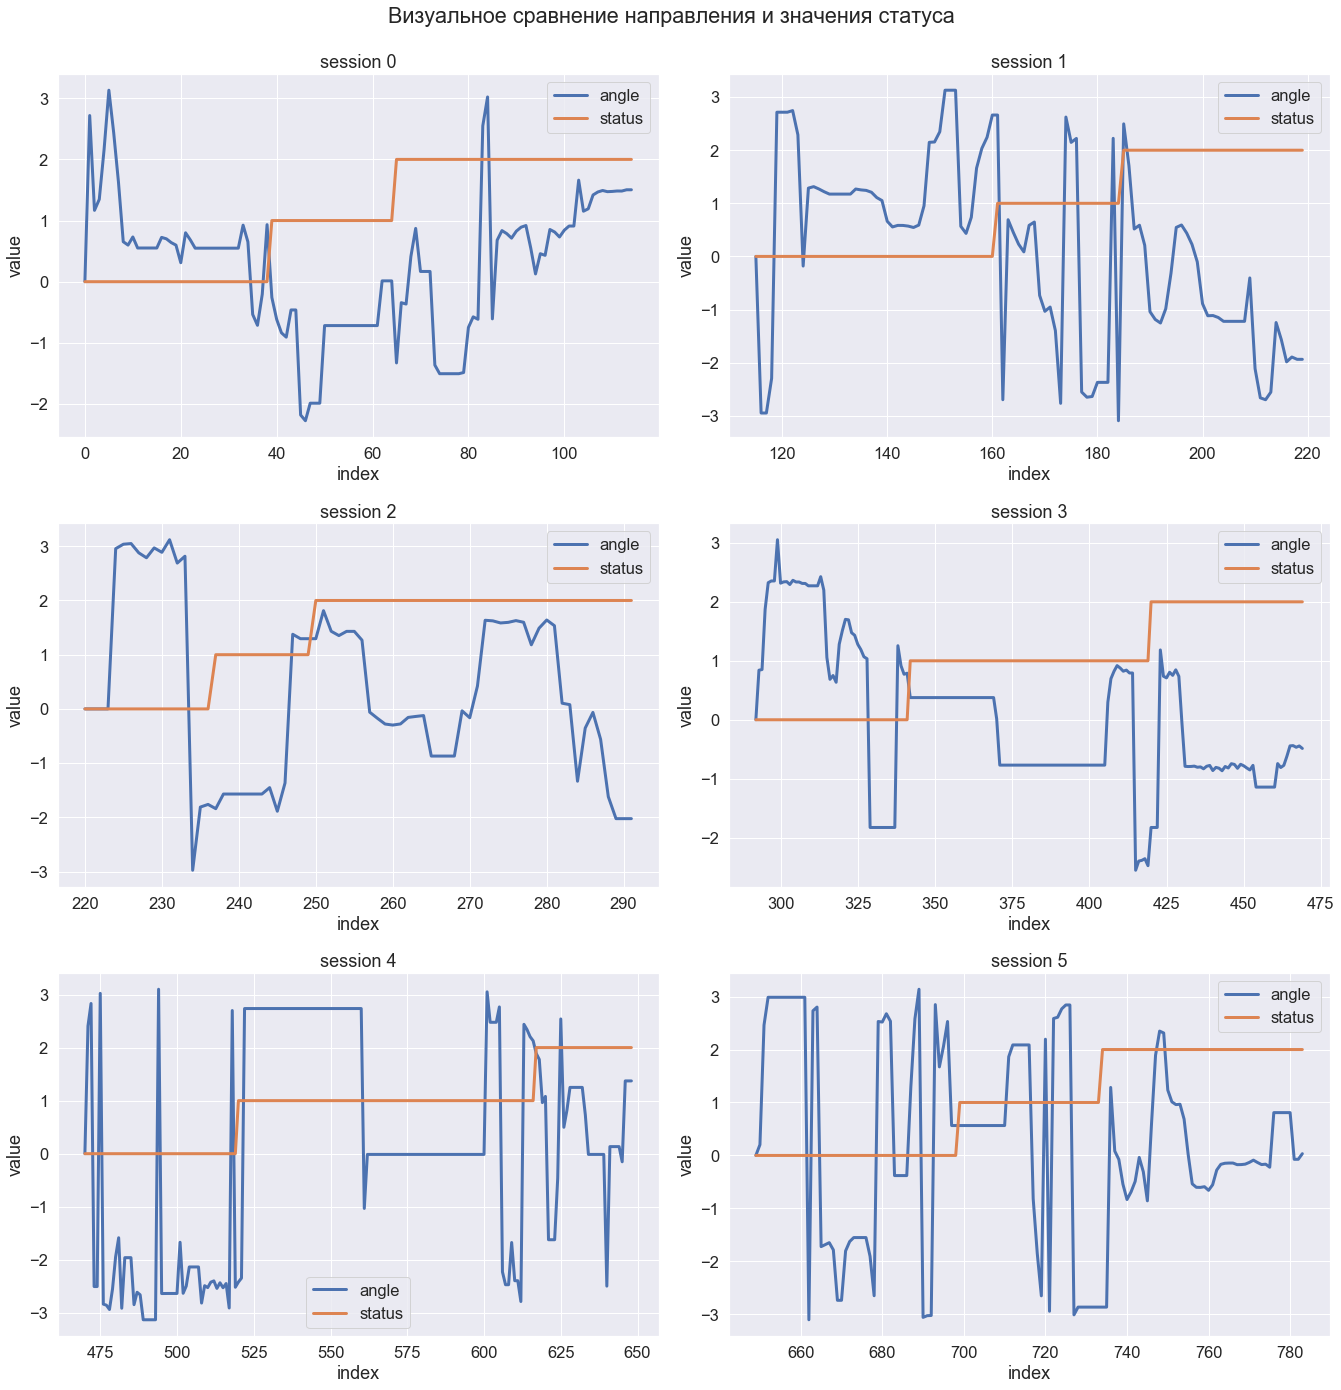

In [60]:
plt.figure(figsize=(19, 19))
plt.suptitle('Визуальное сравнение направления и\
 значения статуса', y=1.02, x=0.5)

for i in range(6):
    plt.subplot(3, 2, i+1)
    
    plt.plot(new_sessions[i].index, new_sessions[i].angle, lw=3,
             label='angle')
    plt.plot(new_sessions[i].index, new_sessions[i].status, lw=3,
            label='status')
    
    plt.title(f'session {i}')
    plt.xlabel('index')
    plt.ylabel('value')
    
    plt.legend()
    
    
plt.tight_layout()

Визуально трудно оценить, есть ли какая-нибудь зависимость, поэтому обратимся к критериям проверки независимости хи-квадрат и Манна-Уитни.

Чтобы использовать хи-квадрат, будем разбивать вещественный признак на бины. Для корректной работы, удалим все сессии, где машина просто стоит на месте.

In [63]:
grouped = new_data.groupby('session').sum()
useless_sessions = grouped[grouped.x_diff == 0.0][grouped.y_diff == 0.0].index.values
new_data = new_data[~new_data.session.isin(useless_sessions)]

In [64]:
chi_pvalues = []
mw_rejects = []

session_values = np.unique(new_data.session)

for session in tqdm_notebook(session_values):
    # хи-квадрат
    session_data = new_data[new_data.session == session]
    obs = np.histogram2d(session_data['status'],
                         session_data['angle'],
                         bins=(2, 2))[0]
    chi_pvalues.append(sps.chi2_contingency(obs)[1])

    # если таксист стоит на месте, то его угол = 0, Манн-Уитни выдаст ошибку
    if session_data[session_data.status == 0].angle.sum() == 0:
        continue
    if session_data[session_data.status == 1].angle.sum() == 0:
        continue
    if session_data[session_data.status == 2].angle.sum() == 0:
        continue
    
    # Манн-Уитни
    mw_pv = []
    mw_pv.append(sps.mannwhitneyu(
        session_data[session_data.status == 0].angle,
        session_data[session_data.status == 1].angle,
        alternative='two-sided')[1])
    
    mw_pv.append(sps.mannwhitneyu(
        session_data[session_data.status == 0].angle,
        session_data[session_data.status == 2].angle,
        alternative='two-sided')[1])
    
    mw_pv.append(sps.mannwhitneyu(
        session_data[session_data.status == 1].angle,
        session_data[session_data.status == 2].angle,
        alternative='two-sided')[1])
    
    rejects = multipletests(mw_pv)[0]
    if rejects.sum() > 0:  # если хотя бы для одной пары отвергаем
        mw_rejects.append(True)  # то отвергаем для всей сессии
    else:
        mw_rejects.append(False)

ValueError: All numbers are identical in mannwhitneyu

In [65]:
print('Доля отвержений с помощью крит. Хи-квадрат {}'.
      format(multipletests(chi_pvalues)[0].mean()))

print('Доля отвержений с помощью крит. Манна-Уитни {}'.
      format(np.mean(mw_rejects)))

Доля отвержений с помощью крит. Хи-квадрат 0.3157894736842105
Доля отвержений с помощью крит. Манна-Уитни 0.7526881720430108


Как видим, с помощью хи-квадрат отвергается не очень большая доля гипотез о независимости статуса и угла внутри каждой сессии. Это вероятнее всего происходит из-за того, что для применимости критерия пришлось использовать лишь два бина и для статуса, и для направления движения, но даже небольшая доля означает, что в некоторых сессиях зависимость угла от статуса действительно есть.

Манн-Уитни отвергает гипотезу в большинстве случаев.

**Вывод:** угол направления движения действительно может быть полезным при решении задачи.

Проведем похожий анализ и для остальных признаков.

### 4. Корреляция признаков

Наверняка для определения точки посадки пассажира в дальнейшем мы будем отслеживать изменения статуса (это ключевой признак), поэтому логично будет проверить гипотезу о независимости статуса от остальных признаков в датасете, чтобы примерно понимать, чем стоит и чем не стоит пользоваться в дальнейшем решении.  

Очевидно, что гипотеза о нормальности будет отвергаться для наших выборок, вот пример для времени между двумя точками фиксации статуса:

In [66]:
sps.shapiro(new_data.ts)

(0.9099143743515015, 0.0)

Поэтому при анализе зависимостей, будем использовать коэффициент корреляции Спирмена, который не требователен к нормальности.

In [67]:
p_values = []

for feat in ['ts', 'delay', 'dist', 'av_speed']:
    p_values.append(sps.spearmanr(new_data.dropna()[feat],
                                  new_data.dropna().status)[1])

multipletests(p_values)

(array([ True,  True,  True,  True]),
 array([0., 0., 0., 0.]),
 0.012741455098566168,
 0.0125)

Как видим, для всех признаков гипотеза о независимости отвергается, а значит все они важны и обязательно нам пригодятся. 

Повезло, что критерия Спирмена оказалось достаточно. Если бы результаты были статистически не значимы, скорее всего, стоило бы прибегнуть к разбиению вещественных признаков на корзины и применению критерия хи-квадрат, а там в силу разнородности сессий пришлось бы вручную подгонять бины и результат мог бы получиться плохим.

Тем не менее, дисперсионный анализ все равно стоит провести.

### 5. Дисперсионный анализ

Чтобы понимать зависимость категориального признака от вещественного, будем делить вещественный признак на три выборки (статус = 0, 1 или 2) в зависимости от статуса. К получившимся трем выборкам попарно будем применять критерий Манна-Уитни. Если хотя бы для одной пары гипотеза о равенстве распределений отвергнется, то будем считать, что признак значим.

In [68]:
status_0 = new_data[new_data.status == 0]
status_1 = new_data[new_data.status == 1]
status_2 = new_data[new_data.status == 2]

for feat in ['ts', 'delay', 'dist', 'av_speed']:
    p_values = []
    p_values.append(sps.mannwhitneyu(status_0[feat], status_1[feat],
                                     alternative='two-sided')[1])
    p_values.append(sps.mannwhitneyu(status_0[feat], status_2[feat],
                                     alternative='two-sided')[1])
    p_values.append(sps.mannwhitneyu(status_2[feat], status_1[feat],
                                     alternative='two-sided')[1])
    reject = multipletests(p_values)[0]
    print(f'{feat}: {reject}')

ts: [ True  True  True]
delay: [ True  True  True]
dist: [ True  True  True]
av_speed: [ True  True  True]


Результаты получились такие же, как и при корреляционном анализе: все признаки значимы